In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
# import sys
# sys.path.append('/home/bzw/d2l/')
# import d2l as d2l
from torch.utils.data import DataLoader, TensorDataset, random_split
import random

In [2]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
def use_svg_display():
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
set_figsize()

In [3]:
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
def load_variable(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

In [4]:
def try_gpu(i=0):
    'Return gpu(i) if exists, otherwise return cpu().'
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [5]:
num_samples = 2880
dim_output = 5120
labels = np.zeros((num_samples, dim_output))
for i in range(1, num_samples + 1):
    with open(f'//root/autodl-tmp/ljy/data_13/sample_spikeCount_grid_test_{i}.bin') as f:
        sample_size = np.fromfile(f, dtype='uint32', count=1)[0] #
        sample_t0, sample_t1 = np.fromfile(f, dtype='float32', count=2) #
        sample_ID = np.fromfile(f, dtype='uint32', count=sample_size)
        sample_spike_count = np.fromfile(f, dtype='uint32', count=sample_size)
        labels[i-1] = sample_spike_count
# sample_size, sample_t0, sample_t1, sample_ID, sample_spike_count
labels

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [ 30.,   0., 135., ..., 275., 289.,   4.],
       [  1.,   0.,  52., ..., 285., 326., 165.],
       [  0.,   0.,   0., ..., 289., 292., 350.]])

In [6]:
dim_input = 10
features = np.zeros((num_samples, dim_input))
for i in range(1, num_samples + 1):
    with open(f'//root/autodl-tmp/ljy/resource_11/static_color-random_{i}_cfg.bin') as f:
        features_sample = np.fromfile(f, dtype='float32', count=-1)
    features[i-1] = features_sample
features

array([[4.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01],
       [4.00000000e+00, 0.00000000e+00, 3.00000000e+01, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01],
       [4.00000000e+00, 0.00000000e+00, 6.00000000e+01, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01],
       ...,
       [4.20000000e+01, 1.65000000e+02, 2.70000000e+02, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01],
       [4.20000000e+01, 1.65000000e+02, 3.00000000e+02, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01],
       [4.20000000e+01, 1.65000000e+02, 3.30000000e+02, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01]])

In [7]:
features.shape, labels.shape

((2880, 10), (2880, 5120))

In [8]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

In [9]:
features_df = pd.DataFrame(features)
features_df

,0,1,2,3,4,5,6,7,8,9
0,4.0,0.0,0.0,0.3,0.8,0.2,0.5,0.2,0.8,0.5
1,4.0,0.0,30.0,0.3,0.8,0.2,0.5,0.2,0.8,0.5
2,4.0,0.0,60.0,0.3,0.8,0.2,0.5,0.2,0.8,0.5
3,4.0,0.0,90.0,0.3,0.8,0.2,0.5,0.2,0.8,0.5
4,4.0,0.0,120.0,0.3,0.8,0.2,0.5,0.2,0.8,0.5
...,...,...,...,...,...,...,...,...,...,...
2875,42.0,165.0,210.0,0.3,0.8,0.2,0.5,0.2,0.8,0.5
2876,42.0,165.0,240.0,0.3,0.8,0.2,0.5,0.2,0.8,0.5
2877,42.0,165.0,270.0,0.3,0.8,0.2,0.5,0.2,0.8,0.5
2878,42.0,165.0,300.0,0.3,0.8,0.2,0.5,0.2,0.8,0.5


In [10]:
# numerical_features = features.dtypes[features.dtypes != 'object'].index
features_df_pre = features_df.apply(
    lambda x : (x - x.mean()) / x.std()
)
features_df_pre = features_df_pre.fillna(0)

In [11]:
features_df_pre

,0,1,2,3,4,5,6,7,8,9
0,-1.647223,-1.592978,-1.592978,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.647223,-1.592978,-1.303346,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.647223,-1.592978,-1.013714,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.647223,-1.592978,-0.724081,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.647223,-1.592978,-0.434449,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2875,1.647223,1.592978,0.434449,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2876,1.647223,1.592978,0.724081,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2877,1.647223,1.592978,1.013714,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2878,1.647223,1.592978,1.303346,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
labels_all = labels

In [13]:
labels_all.shape

(2880, 5120)

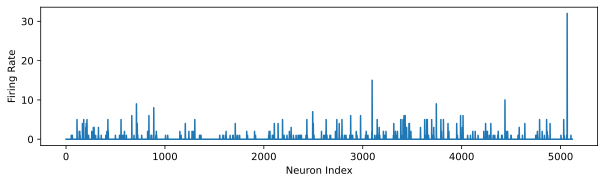

In [14]:
set_figsize((10, 2.5))
plt.plot(labels_all[406, :])
# plt.title('Firing Rate')
plt.xlabel('Neuron Index')
plt.ylabel('Firing Rate')
plt.show()

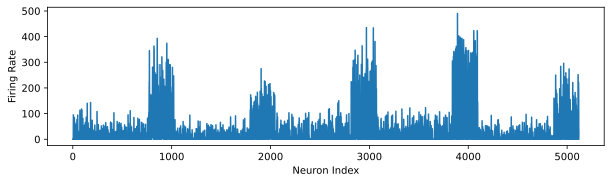

In [15]:
set_figsize((10, 2.5))
plt.plot(labels_all[1000, :])
# plt.title('Firing Rate')
plt.xlabel('Neuron Index')
plt.ylabel('Firing Rate')
plt.show()

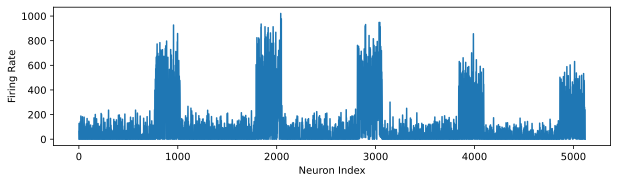

In [16]:
set_figsize((10, 2.5))
plt.plot(labels_all[2000, :])
# plt.title('Firing Rate')
plt.xlabel('Neuron Index')
plt.ylabel('Firing Rate')
plt.show()

In [17]:
def lst_func(start, end, peri):
    lst = []
    for i in range(5):
        lst += list(range(start + i * peri, end + i * peri))
    return lst
lst = lst_func(0, 768, 1024) # 取出兴奋性神经元的输出
len(lst)

3840

In [18]:
features = features_df_pre.values[:, :3]
labels = labels_all[:, lst_func(0, 768, 1024)]
features = torch.tensor(features, dtype = torch.float32)
labels = torch.tensor(labels, dtype = torch.float32)
dataset = torch.utils.data.TensorDataset(features, labels)

In [19]:
dataset_simple = torch.utils.data.TensorDataset(features[406].reshape(1, -1), labels[406].reshape(1, -1))

In [20]:
test_size = int(0.2 * labels.shape[0]) # 2880 * 0.2 = 576
train_size = labels.shape[0] - test_size
train_dataset, val_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))

In [21]:
train_size1 = 1
train_size2 = int(2880 * 0.8) - train_size1
train_dataset1, train_dataset2 = random_split(train_dataset, [train_size1, train_size2], generator=torch.Generator().manual_seed(2))

In [22]:
labels_all

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [ 30.,   0., 135., ..., 275., 289.,   4.],
       [  1.,   0.,  52., ..., 285., 326., 165.],
       [  0.,   0.,   0., ..., 289., 292., 350.]])

In [23]:
np.sum(labels.numpy()>500)

0

In [24]:
import numpy as np
import torch
import os
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, save_path, patience=20, verbose=False, delta=0):
        """
        Args:
            save_path : 模型保存文件夹
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.save_path = save_path
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        path = os.path.join(self.save_path, 'best_network.pth')
        # torch.save(model.state_dict(), path)	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss

In [25]:
import time
class Timer:
    'Record multiple running times.'
    def __init__(self):
        self.times = []
        self.start()
 
    def start(self):
       self.tik = time.time()
 
    def stop(self):
       self.times.append(time.time() - self.tik)
       return self.times[-1]
 
    def avg(self):
        return sum(self.times) / len(self.times)
 
    def sum(self):
        return sum(self.times)
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()
class Accumulator:
    'For accumulating sums over `n` variables.'
    def __init__(self, n):
        self.data = [0.0] * n
 
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
 
    def reset(self):
        self.data = [0.0] * len(self.data)
 
    def __getitem__(self, idx):
        return self.data[idx]

In [26]:
def train(net, train_iter, num_epochs, lr, device, test_iter=None):
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    timer, num_batches = Timer(), len(train_iter)
    train_ls, test_ls, test_MAE_ls = [], [], []
    # train_accs, test_accs = [], []
    for epoch in range(num_epochs):
        # print(epoch)
        metric = Accumulator(2)  
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], X.shape[0])
            timer.stop()
            train_l = np.sqrt(metric[0] / metric[1])
            if (i + 1) % (num_batches // 1) == 0 or i == num_batches - 1:
                # print(f'{i}, train_loss: {train_l}')
                train_ls.append(train_l)
        net.eval()
        metric2 = Accumulator(3)
        if test_iter != None:
            with torch.no_grad():
                for (X_test,y_test) in test_iter:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    y_hat = net(X_test)
                    l = loss(y_hat, y_test)
                    l_MAE = loss_MAE(y_hat, y_test)
                    metric2.add(l * X_test.shape[0], l_MAE * X_test.shape[0], X_test.shape[0])
                test_l = np.sqrt(metric2[0] / metric2[2])
                test_l_MAE = metric2[1] / metric2[2]
                test_ls.append(test_l)
                test_MAE_ls.append(test_l_MAE)
        # # 早停止
        # early_stopping(test_l, net)
        # #达到早停止条件时，early_stop会被置为True
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break #跳出迭代，结束训练
    if test_iter != None:
        print(f'train loss {train_l:.3f}', 
                f'test loss {test_l:.3f}')
    else:
        print(f'train loss {train_l:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    return train_ls, test_ls, test_MAE_ls

In [27]:
# One Hidden
num_inputs, num_outputs, num_hiddens = 3, 768*5, 500
loss = nn.MSELoss()
loss_MAE = nn.L1Loss()
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            # nn.Dropout(p=0.2),
            # nn.BatchNorm1d(num_hiddens),
            nn.Sigmoid(),
            nn.Linear(num_hiddens, num_hiddens),
            # nn.Dropout(p=0.2),
            # nn.BatchNorm1d(num_hiddens),
            nn.Sigmoid(),
            nn.Linear(num_hiddens, num_hiddens),
            # nn.BatchNorm1d(num_hiddens),
            nn.Sigmoid(),
            nn.Linear(num_hiddens, num_hiddens),
            # nn.Dropout(p=0.2),
            # nn.BatchNorm1d(num_hiddens),
            nn.Sigmoid()
        )
        self.output_layer = nn.Linear(num_hiddens, num_outputs)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear_stack(x)
        y = self.output_layer(x)
        y = self.relu(y)
        return y
net = NeuralNetwork()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        # nn.init.normal_(m.weight, 0, 0.4)
net.apply(init_weights)
batch_size, num_epochs, lr = 256, 2000, 1e-3
train_iter = torch.utils.data.DataLoader(dataset_simple, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True)
train_ls, test_ls, test_MAE_ls = train(net, train_iter, num_epochs, lr, try_gpu(2), test_iter)

training on cuda:2
train loss 0.425 test loss 38.410
404.9 examples/sec on cuda:2


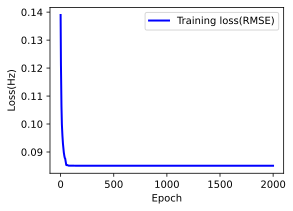

In [28]:
set_figsize((3.5*1.2, 2.5*1.2))
plt.plot(np.array(train_ls) / 5, '-', linewidth=2, color='b', label='Training loss(RMSE)')
# plt.plot(train_MAE_ls, linewidth=2, color='m', label='Test loss MAE')
# plt.show()

# plt.plot(np.array(test_ls) / 5, '--', linewidth=2, color='r', label='Test loss(RMSE)')
# plt.plot(np.array(test_MAE_ls) / 5, '-.', linewidth=2, color='g', label='Test loss(MAE)')
plt.xlabel('Epoch')
plt.ylabel('Loss(Hz)')
plt.legend()
# plt.ylim(0, 12)
plt.show()

In [26]:
def train_early_stopping(net, train_iter, num_epochs, lr, device, test_iter=None):
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    timer, num_batches = Timer(), len(train_iter)
    train_ls, test_ls, test_MAE_ls = [], [], []
    # train_accs, test_accs = [], []
    for epoch in range(num_epochs):
        # print(epoch)
        metric = Accumulator(2)  
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], X.shape[0])
            timer.stop()
            train_l = np.sqrt(metric[0] / metric[1])
            if (i + 1) % (num_batches // 1) == 0 or i == num_batches - 1:
                # print(f'{i}, train_loss: {train_l}')
                train_ls.append(train_l)
        net.eval()
        metric2 = Accumulator(3)
        if test_iter != None:
            with torch.no_grad():
                for (X_test,y_test) in test_iter:
                    X_test, y_test = X_test.to(device), y_test.to(device)
                    y_hat = net(X_test)
                    l = loss(y_hat, y_test)
                    l_MAE = loss_MAE(y_hat, y_test)
                    metric2.add(l * X_test.shape[0], l_MAE * X_test.shape[0], X_test.shape[0])
                test_l = np.sqrt(metric2[0] / metric2[2])
                test_l_MAE = metric2[1] / metric2[2]
                test_ls.append(test_l)
                test_MAE_ls.append(test_l_MAE)
        # 早停止
        early_stopping(test_l, net)
        #达到早停止条件时，early_stop会被置为True
        if early_stopping.early_stop:
            print("Early stopping")
            break #跳出迭代，结束训练
    if test_iter != None:
        print(f'train loss {train_l:.3f}', 
                f'test loss {test_l:.3f}')
    else:
        print(f'train loss {train_l:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    return train_ls, test_ls, test_MAE_ls

In [27]:
# One Hidden
num_inputs, num_outputs, num_hiddens = 4, 768*5, 500
loss = nn.MSELoss()
loss_MAE = nn.L1Loss()
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            # nn.Dropout(p=0.2),
            nn.Sigmoid(),
            nn.Linear(num_hiddens, num_hiddens),
            # nn.Dropout(p=0.2),
            nn.Sigmoid(),
            nn.Linear(num_hiddens, num_hiddens),
            # nn.Dropout(p=0.2),
            nn.Sigmoid(),
        )
        self.output_layer = nn.Linear(num_hiddens, num_outputs)
    def forward(self, x):
        x = self.linear_stack(x)
        y = self.output_layer(x)
        return y
net = NeuralNetwork()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        # nn.init.normal_(m.weight, 0, 0.4)
net.apply(init_weights)
batch_size, num_epochs, lr = 128, 500, 5 * 1e-4
train_iter = torch.utils.data.DataLoader(train_dataset1, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True)
save_path = "./" #当前目录下
early_stopping = EarlyStopping(save_path, patience=300)
train_ls, test_ls, test_MAE_ls = train_early_stopping(net, train_iter, num_epochs, lr, try_gpu(2), test_iter)

training on cuda:2


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x3 and 4x500)

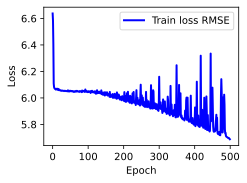

In [ ]:
set_figsize()
plt.plot(train_ls, linewidth=2, color='b', label='Train loss RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

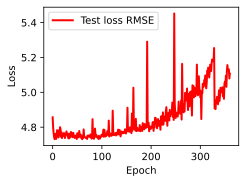

In [ ]:
plt.plot(test_ls, linewidth=2, color='r', label='Test loss RMSE')
# plt.plot(test_MAE_ls, linewidth=2, color='m', label='Test loss MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# One Hidden
num_inputs, num_outputs, num_hiddens = 4, 768*5, 500
loss = nn.MSELoss()
loss_MAE = nn.L1Loss()
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            # nn.Dropout(p=0.2),
            nn.Sigmoid(),
            nn.Linear(num_hiddens, num_hiddens),
            # nn.Dropout(p=0.2),
            nn.Sigmoid(),
            nn.Linear(num_hiddens, num_hiddens),
            # nn.Dropout(p=0.2),
            nn.Sigmoid(),
        )
        self.output_layer = nn.Linear(num_hiddens, num_outputs)
    def forward(self, x):
        x = self.linear_stack(x)
        y = self.output_layer(x)
        return y
net2 = NeuralNetwork()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        # nn.init.normal_(m.weight, 0, 0.4)
net2.apply(init_weights)
batch_size, num_epochs, lr = 128, 1000, 5 * 1e-3
train_iter = torch.utils.data.DataLoader(train_dataset1, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True)
save_path = "./" #当前目录下
early_stopping = EarlyStopping(save_path, patience=30)
train_ls2, test_ls2, test_MAE_ls2 = train_early_stopping(net2, train_iter, num_epochs, lr, try_gpu(2), test_iter)

training on cuda:2
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopping counter: 4 out of 30
EarlyStopping counter: 5 out of 30
EarlyStopping counter: 6 out of 30
EarlyStopping counter: 7 out of 30
EarlyStopping counter: 8 out of 30
EarlyStopping counter: 9 out of 30
EarlyStopping counter: 10 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopping counter: 4 out of 30
EarlyStopping counter: 5 out of 30
EarlyStopping counter: 6 out of 30
EarlyStopping counter: 7 out of 30
EarlyStopping counter: 8 out of 30
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
EarlyStopping counter: 4 out of 30
EarlyStopping counter: 5 out of 30
EarlyStopping counter: 6 out of 30
EarlyStopping counter: 7 out of 30


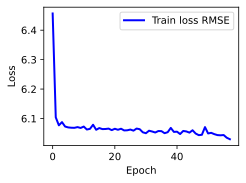

In [ ]:
set_figsize()
plt.plot(train_ls2, linewidth=2, color='b', label='Train loss RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

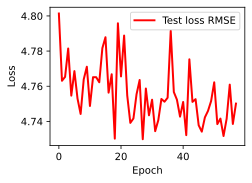

In [ ]:
plt.plot(test_ls2, linewidth=2, color='r', label='Test loss RMSE')
# plt.plot(test_MAE_ls, linewidth=2, color='m', label='Test loss MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
save_variable(train_ls, 'train_ls.pth')
# save_variable(train_ls2, 'train_ls2.pth')
save_variable(test_ls, 'test_ls.pth')
# save_variable(test_ls2, 'test_ls2.pth')
save_variable(test_MAE_ls, 'test_MAE_ls.pth')
# save_variable(test_MAE_ls2, 'test_MAE_ls2.pth')

'test_MAE_ls.pth'

In [100]:
torch.save(net.state_dict(), 'net.pth')
# torch.save(net2.state_dict(), 'net2.pth')

In [103]:
def predict(net, features_test, device):
    net = net.to(device)
    net.eval()
    features_test = features_test.to(device)
    with torch.no_grad():
        y_pred = net(features_test)
    y_pred = y_pred.to('cpu')
    return y_pred.detach()

In [99]:
num_inputs, num_outputs, num_hiddens = 3, 768*5, 500
loss = nn.MSELoss()
loss_MAE = nn.L1Loss()
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            # nn.Dropout(p=0.2),
            # nn.BatchNorm1d(num_hiddens),
            nn.Sigmoid(),
            nn.Linear(num_hiddens, num_hiddens),
            # nn.Dropout(p=0.2),
            # nn.BatchNorm1d(num_hiddens),
            nn.Sigmoid(),
            nn.Linear(num_hiddens, num_hiddens),
            # nn.BatchNorm1d(num_hiddens),
            nn.Sigmoid(),
            nn.Linear(num_hiddens, num_hiddens),
            # nn.Dropout(p=0.2),
            # nn.BatchNorm1d(num_hiddens),
            nn.Sigmoid()
        )
        self.output_layer = nn.Linear(num_hiddens, num_outputs)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear_stack(x)
        y = self.output_layer(x)
        y = self.relu(y)
        return y
net2 = NeuralNetwork()
net2.load_state_dict(torch.load('net.pth'))

<All keys matched successfully>

In [105]:
batch_size, num_epochs, lr = 10000, 7000, 1e-3
train_iter = torch.utils.data.DataLoader(train_dataset1, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True)
for batch in test_iter:
    features, labels = batch
    preds = predict(net, features, try_gpu(2))
    print(labels, preds)
    break

tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   1.],
        [  0.,   0.,   0.,  ...,   0.,   0.,  65.],
        [  0.,   0.,   0.,  ...,   0.,   0.,  37.],
        ...,
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  9.,   0.,   0.,  ...,   0.,   0., 110.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.]]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [119]:
simple_iter = torch.utils.data.DataLoader(dataset_simple, batch_size, shuffle=True)
for batch in simple_iter:
    features, labels2 = batch
    preds2 = predict(net, features, try_gpu(2))
    print(labels2, preds2)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.]]) tensor([[0., 0., 0.,  ..., 0., 0., 0.]])


In [46]:
labels.shape

torch.Size([576, 3840])

In [89]:
random.seed(1)
ls1 = random.sample(list(range(labels.numpy().size)), 10000)
ls2 = random.sample(list(range(labels2.numpy().size)), 3840)

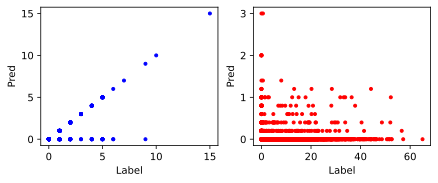

In [120]:
set_figsize((3.5*2, 2.5))
plt.subplot(1, 2, 1)
plt.plot(labels2.reshape(-1, )[ls2], preds2.reshape(-1, )[ls2], 'bo', markersize=3, label='Label')
# plt.plot(, 'ro', markersize=2, label='Pred')
plt.xlabel('Label')
plt.ylabel('Pred')

plt.subplot(1, 2, 2)
plt.plot(labels.reshape(-1, )[ls1]/5, preds.reshape(-1, )[ls1]/5, 'ro', markersize=3, label='Label')
# plt.plot(, 'ro', markersize=2, label='Pred')
plt.xlabel('Label')
plt.ylabel('Pred')
plt.show()

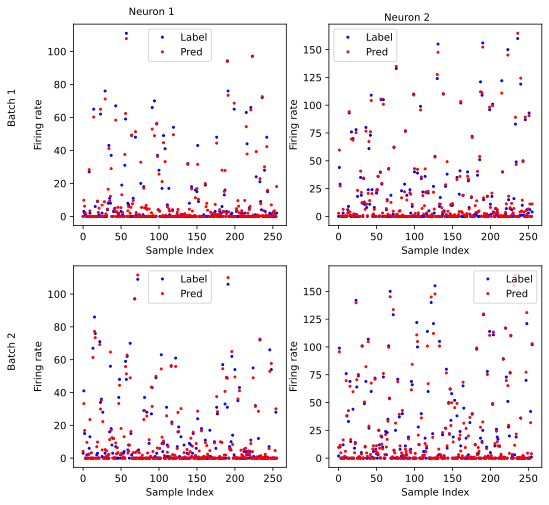

In [28]:
set_figsize((4.2 * 2, 4 * 2))
plt.subplot(2, 2, 1)
plt.plot(labels[:, 0], 'bo', markersize=2, label='Label')
plt.plot(preds[:, 0], 'ro', markersize=2, label='Pred')
plt.xlabel('Sample Index')
plt.ylabel('Firing rate')
plt.text(-100, max(labels[:, 0]) / 2, 'Batch 1', rotation='90')
plt.text(60, max(labels[:, 0]) + 0.1 * max(labels[:, 0]), 'Neuron 1')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(labels[:, 1000], 'bo', markersize=2, label='Label')
plt.plot(preds[:, 1000], 'ro', markersize=2, label='Pred')
plt.xlabel('Sample Index')
plt.ylabel('Firing rate')
plt.text(60, max(labels[:, 1000]) + 0.1 * max(labels[:, 1000]), 'Neuron 2')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(labels2[:, 0], 'bo', markersize=2, label='Label')
plt.plot(preds2[:, 0], 'ro', markersize=2, label='Pred')
plt.text(-100, max(labels2[:, 0]) / 2, 'Batch 2', rotation='90')
plt.xlabel('Sample Index')
plt.ylabel('Firing rate')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(labels2[:, 1000], 'bo', markersize=2, label='Label')
plt.plot(preds2[:, 1000], 'ro', markersize=2, label='Pred')
plt.xlabel('Sample Index')
plt.ylabel('Firing rate')
plt.legend()
plt.show()

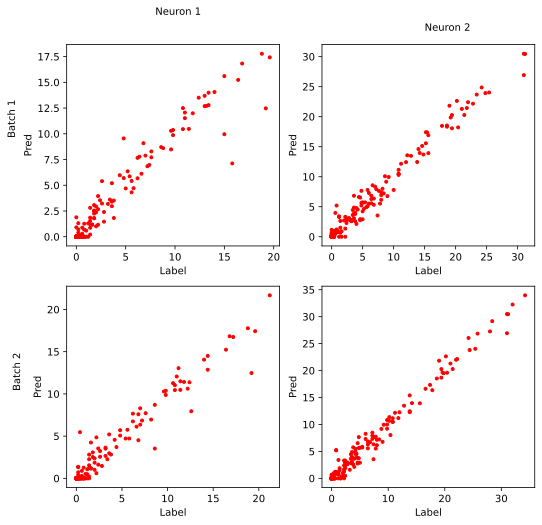

In [43]:
set_figsize((4.2 * 2, 4 * 2))
plt.subplot(2, 2, 1)
plt.plot(labels[:, 0]/5, preds[:, 0]/5, 'ro', markersize=3, label='Label')
# plt.plot(, 'ro', markersize=2, label='Pred')
plt.xlabel('Label')
plt.ylabel('Pred')
plt.text(-7, max(labels[:, 0]/5) / 2, 'Batch 1', rotation='90')
plt.text(8, max(labels[:, 0]/5) + 0.1 * max(labels[:, 0]/5), 'Neuron 1')
# plt.legend()
plt.subplot(2, 2, 2)
plt.plot(labels[:, 1000]/5, preds[:, 1000]/5, 'ro', markersize=3, label='Label')
# plt.plot(, 'ro', markersize=2, label='Pred')
plt.xlabel('Label')
plt.ylabel('Pred')
plt.text(15, max(labels[:, 1000]/5) + 0.1 * max(labels[:, 1000]/5), 'Neuron 2')
# plt.legend()
plt.subplot(2, 2, 3)
plt.plot(labels2[:, 0]/5, preds2[:, 0]/5, 'ro', markersize=3, label='Label')
# plt.plot(, 'ro', markersize=2, label='Pred')
plt.text(-7, max(labels2[:, 0]/5) / 2, 'Batch 2', rotation='90')
plt.xlabel('Label')
plt.ylabel('Pred')
# plt.legend()
plt.subplot(2, 2, 4)
plt.plot(labels2[:, 1000]/5, preds2[:, 1000]/5, 'ro', markersize=3, label='Label')
# plt.plot(, 'ro', markersize=2, label='Pred')
plt.xlabel('Label')
plt.ylabel('Pred')
# plt.legend()
plt.show()

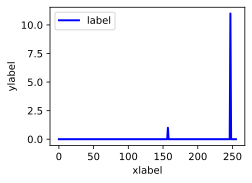

In [44]:
# 确实存在几乎不发放的神经元，网络会把他预测为 0
set_figsize()
plt.plot(labels2[:, 1], linewidth=2, color='b', label='label')
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.legend()
plt.show()

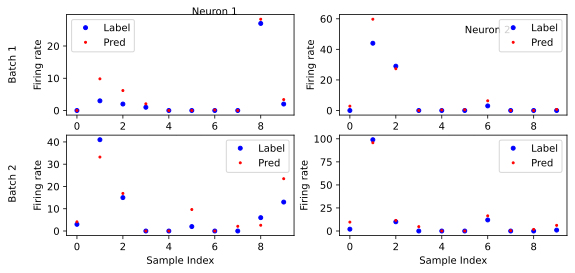

In [30]:
set_figsize((4.5 * 2, 2 * 2))
plt.subplot(2, 2, 1)
plt.plot(labels[:10, 0], 'bo', markersize=4, label='Label')
plt.plot(preds[:10, 0], 'ro', markersize=2, label='Pred')
plt.xlabel('Sample Index')
plt.ylabel('Firing rate')
plt.text(-3, max(labels[:10, 0]) / 3, 'Batch 1', rotation='90')
plt.text(5, max(labels[:10, 0]) + 0.1 * max(labels[:10, 0]), 'Neuron 1')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(labels[:10, 1000], 'bo', markersize=4, label='Label')
plt.plot(preds[:10, 1000], 'ro', markersize=2, label='Pred')
plt.xlabel('Sample Index')
plt.ylabel('Firing rate')
plt.text(5, max(labels[:10, 1000]) + 0.15 * max(labels[:10, 1000]), 'Neuron 2')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(labels2[:10, 0], 'bo', markersize=4, label='Label')
plt.plot(preds2[:10, 0], 'ro', markersize=2, label='Pred')
plt.text(-3, max(labels2[:10, 0]) / 3, 'Batch 2', rotation='90')
plt.xlabel('Sample Index')
plt.ylabel('Firing rate')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(labels2[:10, 1000], 'bo', markersize=4, label='Label')
plt.plot(preds2[:10, 1000], 'ro', markersize=2, label='Pred')
plt.xlabel('Sample Index')
plt.ylabel('Firing rate')
plt.legend()
plt.show()

In [45]:
data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=False)
preds_test = np.empty((1, 3840))
for batch in data_iter:
    features, labels = batch
    preds = predict(net2, features, try_gpu(2))
    # preds_0 = preds
    preds_test = np.vstack((preds_test, preds))
preds_test.shape

(2881, 3840)

In [46]:
preds_test = preds_test[1:]
preds_test.shape

(2880, 3840)

In [47]:
save_variable(preds_test, 'preds_all.npy')

'preds_all.npy'

## Prediction on randomly generated data

In [83]:
num_samples = 400
dim_output = 3840
labels2 = np.zeros((num_samples, dim_output))
for i in range(1, num_samples + 1):
    with open(f'//root/autodl-tmp/ljy/data_random_valid/sample_spikeCount_random_valid_test_{i}.bin') as f:
        sample_size = np.fromfile(f, dtype='uint32', count=1)[0] #
        sample_t0, sample_t1 = np.fromfile(f, dtype='float32', count=2) #
        sample_ID = np.fromfile(f, dtype='uint32', count=sample_size)
        sample_spike_count = np.fromfile(f, dtype='uint32', count=sample_size)
        labels2[i-1] = sample_spike_count
# sample_size, sample_t0, sample_t1, sample_ID, sample_spike_count
labels2

array([[  0.,   0., 162., ...,   0.,   0.,   4.],
       [  0.,   0.,   0., ...,   0.,   0.,   6.],
       [  0.,   0.,  15., ...,   0.,   0.,  11.],
       ...,
       [ 16.,   0.,  35., ...,   0.,   0.,   0.],
       [ 52.,   0., 114., ...,   0.,   0.,   0.],
       [  2.,   0.,   0., ...,   0.,   0.,   0.]])

In [84]:
dim_input = 10
features2 = np.zeros((num_samples, dim_input))
for i in range(1, num_samples + 1):
    with open(f'//root/autodl-tmp/ljy/resource_random_valid/static_color-random_{i}_cfg.bin') as f:
        features_sample = np.fromfile(f, dtype='float32', count=-1)
    features2[i-1] = features_sample
features2

array([[4.14953423e+01, 1.48100174e+02, 1.66641525e+02, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01],
       [3.07826729e+01, 1.41015472e+02, 9.75577698e+01, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01],
       [5.51623840e+01, 1.06716721e+02, 3.33436096e+02, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01],
       ...,
       [4.24274483e+01, 1.31568823e+01, 2.72214294e+02, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01],
       [2.18052444e+01, 2.90565262e+01, 2.82152344e+02, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01],
       [4.12186050e+01, 6.71747818e+01, 4.44651451e+01, ...,
        2.00000003e-01, 8.00000012e-01, 5.00000000e-01]])

In [85]:
features2.shape, labels2.shape

((400, 10), (400, 3840))

In [86]:
features_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,2880.000000,2880.00000,2880.00000,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0,2880.0
mean,23.000000,82.50000,165.00000,0.3,0.8,0.2,0.5,0.2,0.8,0.5
std,11.534565,51.78978,103.57956,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,4.000000,0.00000,0.00000,0.3,0.8,0.2,0.5,0.2,0.8,0.5
25%,13.500000,41.25000,82.50000,0.3,0.8,0.2,0.5,0.2,0.8,0.5
50%,23.000000,82.50000,165.00000,0.3,0.8,0.2,0.5,0.2,0.8,0.5
75%,32.500000,123.75000,247.50000,0.3,0.8,0.2,0.5,0.2,0.8,0.5
max,42.000000,165.00000,330.00000,0.3,0.8,0.2,0.5,0.2,0.8,0.5


In [88]:
# numerical_features = features.dtypes[features.dtypes != 'object'].index
features_df2 = pd.DataFrame(features2)
# features_df_pre = features_df.apply(
#     lambda x : (x - x.mean()) / x.std()
# )
# features_df_pre = features_df_pre.fillna(0)

In [90]:
features_df2[0] = (features_df2[0]-23)/11.53
features_df2[1] = (features_df2[1]-82.5)/51.79
features_df2[3] = (features_df2[2]-165)/103.60

In [ ]:
features_df

In [91]:
features = features_df2.values[:, :3]
# labels = labels_all[:, lst_func(0, 768, 1024)]
features = torch.tensor(features, dtype = torch.float32)
labels = torch.tensor(labels, dtype = torch.float32)
# dataset = torch.utils.data.TensorDataset(features, labels)

In [92]:
preds_random = predict(net2, features, try_gpu(2))

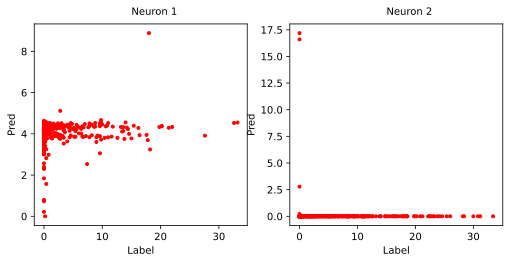

In [93]:
set_figsize((4.2 * 2, 4 * 2))
plt.subplot(2, 2, 1)
plt.plot(labels[:, 0]/5, preds_random[:, 0]/5, 'ro', markersize=3, label='Label')
# plt.plot(, 'ro', markersize=2, label='Pred')
plt.xlabel('Label')
plt.ylabel('Pred')
# plt.text(-7, max(labels[:, 0]) / 2, 'Batch 1', rotation='90')
plt.text(15, max(preds_random[:, 0]/5) + 0.1 * max(preds_random[:, 0]/5), 'Neuron 1')
# plt.legend()
plt.subplot(2, 2, 2)
plt.plot(labels[:, 1000]/5, preds_random[:, 1000]/5, 'ro', markersize=3, label='Label')
# plt.plot(, 'ro', markersize=2, label='Pred')
plt.xlabel('Label')
plt.ylabel('Pred')
plt.text(15, max(preds_random[:, 1000]/5) + 0.1 * max(preds_random[:, 1000]/5), 'Neuron 2')
# plt.legend()
plt.show()